Import required libraries

In [33]:
#install the yahoo finance  
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.59)


In [34]:
!pip install -U "scikit-learn==0.24"

Requirement already up-to-date: scikit-learn==0.24 in /usr/local/lib/python3.7/dist-packages (0.24.0)


In [35]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import numpy as np
np.random.seed(7)
import pandas as pd
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, SimpleRNN,Dense,Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from keras.layers.recurrent import LSTM
from sklearn.metrics import accuracy_score
import os.path
from os import path
import numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from sklearn.metrics import mean_absolute_percentage_error
import keras
keras.backend.set_epsilon(1)

Collect data

In [36]:
#https://finance.yahoo.com/sector/ms_financial_services
ticker_list=['BRK-B','BRK-A','MSFT','AAPL','FB','JPM']
today = date.today()
l = len(ticker_list)
df_dict = {} # creating a dictionay for the data
files=[]
sector=[]
for i in range(0,l):
  sector = yf.Ticker(ticker_list[i]).info['sector']
  if path.exists('./'+sector) == False:
    os.mkdir('./'+sector)
  else:
    print("folder already exist");
# we are getting the data with a start and end
def getData(ticker):
  print(ticker)
  data = pdr.get_data_yahoo(ticker, start="2020-01-01", end="2021-05-17")
  df_dict[ticker] = data # storing the data frames in the dictionary
  dataname= ticker+'_'+str(today)
  files.append(dataname)
  SaveData(data, dataname,yf.Ticker(ticker).info['sector'])

# we are having the data based on the sector of the company
  
def SaveData(df, filename,sector):
  if (sector == 'Financial Services'):
    df.to_csv('./Financial Services/'+filename+'.csv')
  elif (sector == 'Technology'):
    df.to_csv('./Technology/'+filename+'.csv')
  elif (sector == 'Communication Services'):
    df.to_csv('./Communication Services/'+filename+'.csv')
  else:
    print("sector is not being considered");

for ticker in ticker_list:
  getData(ticker)


folder already exist
folder already exist
folder already exist
folder already exist
folder already exist
folder already exist
BRK-B
[*********************100%***********************]  1 of 1 completed
BRK-A
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
FB
[*********************100%***********************]  1 of 1 completed
JPM
[*********************100%***********************]  1 of 1 completed


In [37]:

# finding the features with highest correlation with the close feature
company = 'FB'
df_dict[company].corr()['Adj Close']

Open         0.994230
High         0.997049
Low          0.997447
Close        1.000000
Adj Close    1.000000
Volume      -0.156787
Name: Adj Close, dtype: float64

In [38]:
# we are considering a subset of company featues but we can consider only positively correlated features
df_dict[company].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100
2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400
2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900
2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400
2020-01-08,213.000000,216.240005,212.610001,215.220001,215.220001,13475000


In [39]:

df=df_dict[company].reset_index()[['Adj Close', 'Close', 'High']]
df

,Adj Close,Close,High
0,209.779999,209.779999,209.789993
1,208.669998,208.669998,210.399994
2,212.600006,212.600006,212.779999
3,213.059998,213.059998,214.580002
4,215.220001,215.220001,216.240005
...,...,...,...
340,305.970001,305.970001,314.579987
341,306.529999,306.529999,306.839996
342,302.549988,302.549988,304.959991
343,305.260010,305.260010,308.859985


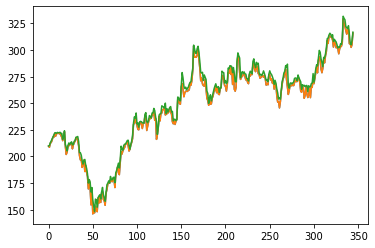

In [40]:
import matplotlib.pyplot as plt
plt.plot(df)

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [42]:
#split dataset into train and test 
split = 0.80
training_size=int(len(df)*split)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [43]:
training_size,test_size

(828, 207)

In [44]:
# converting data into the time_step data
def timestep_data(dataset, time_step=1):
	data_input, data_output = [], []
	for i in range(len(dataset)-time_step-1):
		data1 = dataset[i:(i+time_step), 0]   
		data_input.append(data1)
		data_output.append(dataset[i + time_step, 0])
	return np.array(data_input), np.array(data_output)

In [45]:
# in ltsm we take a previous memory i.e set to values without dependence on the data here it is 30
time_step = 30
x_train, y_train = timestep_data(train_data, time_step)
x_test, y_test = timestep_data(test_data, time_step)

In [46]:
print("x_train shape ",x_train.shape,"y_train shape", y_train.shape,"x_test shape",x_test.shape,"y_test shape",y_test.shape)

x_train shape  (797, 30) y_train shape (797,) x_test shape (176, 30) y_test shape (176,)


In [47]:
#reshape the data before sending it ot the model

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [48]:
#hyperparameters
lr = 1e-3
batch_size = 64
num_epochs = 250


Model

In [49]:
# for most ltsm model the the drop out 0.2 gives the most optimal results 
# return sequence automatically becomes false so must include return_sequences = True that will return one output for each input time step
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2]) ))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')



In [50]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=num_epochs,batch_size=batch_size,verbose=1)

Epoch 1/250
13/13 [==============================] - 9s 172ms/step - loss: 0.1324 - val_loss: 0.0851
Epoch 2/250
13/13 [==============================] - 1s 43ms/step - loss: 0.0225 - val_loss: 0.0125
Epoch 3/250
13/13 [==============================] - 1s 45ms/step - loss: 0.0121 - val_loss: 0.0041
Epoch 4/250
13/13 [==============================] - 1s 44ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 5/250
13/13 [==============================] - 1s 42ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 6/250
13/13 [==============================] - 1s 42ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 7/250
13/13 [==============================] - 1s 43ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 8/250
13/13 [==============================] - 1s 43ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 9/250
13/13 [==============================] - 1s 44ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 10/250
13/13 [==============================] - 1s 43ms/step - loss: 0.0061 - val_loss: 0.007

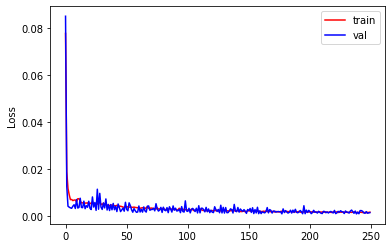

In [51]:
plt.plot( history.history['loss'],c = 'r')
plt.plot(history.history['val_loss'],c = 'b')
plt.ylabel('Loss')
plt.legend(['train','val'],loc = 'upper right')
plt.show()

In [65]:
# predict the train and test data
predict_train=model.predict(x_train)
predict_test=model.predict(x_test)

In [66]:
# metrics for model
rsme = math.sqrt(mean_squared_error(y_test,predict_test))*100
mape = mean_absolute_percentage_error(y_test,predict_test)*100
print("rsme",rsme)
print("mape",mape)

rsme 3.7045456332909414
mape 3.841128227555171


In [67]:
#Transform to its original form
train_predict=scaler.inverse_transform(predict_train)
test_predict=scaler.inverse_transform(predict_test)

In [68]:
# train predictions 

train_predicted_data = np.empty_like(df)
train_predicted_data[:, :] = np.nan
train_predicted_data[time_step:len(train_predict)+time_step, :] = train_predict

In [69]:
# shift and  test predictions 
test_predicted_data = np.empty_like(df)
test_predicted_data[:, :] = numpy.nan
test_predicted_data[len(train_predict)+(time_step*2)+1:len(df)-1, :] = test_predict

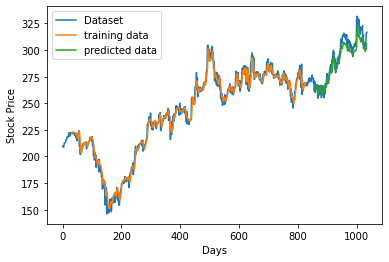

In [70]:
# combine both test and train data predictions
plt.plot(scaler.inverse_transform(df), label='Dataset')
plt.plot(train_predicted_data, label = 'training data')
plt.plot(test_predicted_data, label = 'predicted data')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Predict future days

In [71]:
# to predict the new data we are consider "no_of_steps" no of steps backwards i.e considering pervious time step no of vlues i.e 30
no_of_steps=time_step

In [72]:
#convert to list to append future data
initial_input_data=test_data[(len(test_data)- no_of_steps):].reshape(1,-1)
input_data=list(initial_input_data)
input_data=input_data[0].tolist()

In [73]:
#previous 30 days data
input_data

[0.9503228695655246,
 0.9503228695655246,
 0.9824541996120588,
 0.9276102691812955,
 0.9276102691812955,
 0.9482239237934369,
 0.9096339705643346,
 0.9096339705643346,
 0.9421420892172678,
 0.9365446267423496,
 0.9365446267423496,
 0.9377287021841667,
 0.931485410240914,
 0.931485410240914,
 0.952260522220139,
 0.8609257485819717,
 0.8609257485819717,
 0.9072658196807004,
 0.8639397289339403,
 0.8639397289339403,
 0.8656081764770085,
 0.8425187874863806,
 0.8425187874863806,
 0.8554897434741373,
 0.8571044813945843,
 0.8571044813945843,
 0.8764800224430669,
 0.9145856035709179,
 0.9145856035709179,
 0.9194833627052701]

In [74]:
# predicting values for the next 30 days 
future_output=[]

i=0
while(i<30):
    
    if(len(input_data)>30):
       
        # it is list of input for predicting the future day
        initial_input_data=np.array(input_data[1:])
        print("day {} : input data {}".format(i,initial_input_data))
        initial_input_data=initial_input_data.reshape(1,-1)
        initial_input_data = initial_input_data.reshape((1, no_of_steps, 1))
     
        
        # it is output of the future day
        yhat = model.predict(initial_input_data, verbose=0)
        print("day {} : predicted output data {}".format(i,yhat))
        input_data.extend(yhat[0].tolist())
        input_data=input_data[1:]
       
        # append the data with the present data
        future_output.extend(yhat.tolist())
        i=i+1
    else:
        # we are predicting 1st future day 
        initial_input_data= initial_input_data.reshape((1, no_of_steps,1))
        yhat = model.predict(initial_input_data, verbose=0)
        print(yhat[0])
        input_data.extend(yhat[0].tolist())
        print(len(input_data))
        future_output.extend(yhat.tolist())
        i=i+1
    

print(future_output)

[0.886006]
31
day 1 : input data [0.95032287 0.9824542  0.92761027 0.92761027 0.94822392 0.90963397
 0.90963397 0.94214209 0.93654463 0.93654463 0.9377287  0.93148541
 0.93148541 0.95226052 0.86092575 0.86092575 0.90726582 0.86393973
 0.86393973 0.86560818 0.84251879 0.84251879 0.85548974 0.85710448
 0.85710448 0.87648002 0.9145856  0.9145856  0.91948336 0.886006  ]
day 1 : predicted output data [[0.8740609]]
day 2 : input data [0.9824542  0.92761027 0.92761027 0.94822392 0.90963397 0.90963397
 0.94214209 0.93654463 0.93654463 0.9377287  0.93148541 0.93148541
 0.95226052 0.86092575 0.86092575 0.90726582 0.86393973 0.86393973
 0.86560818 0.84251879 0.84251879 0.85548974 0.85710448 0.85710448
 0.87648002 0.9145856  0.9145856  0.91948336 0.886006   0.87406093]
day 2 : predicted output data [[0.85301423]]
day 3 : input data [0.92761027 0.92761027 0.94822392 0.90963397 0.90963397 0.94214209
 0.93654463 0.93654463 0.9377287  0.93148541 0.93148541 0.95226052
 0.86092575 0.86092575 0.90726582 

Text(0, 0.5, 'Normalized Stock Price')

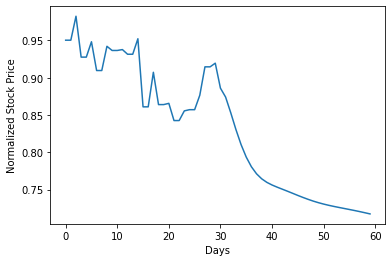

In [75]:
# appending the future 30 days and plotting the graph
df1=df.tolist()
df1.extend(future_output)
plt.plot(df1[(len(df)-no_of_steps):])
plt.xlabel("Days")
plt.ylabel("Normalized Stock Price")

In [76]:
df2=scaler.inverse_transform(df1).tolist()

Text(0, 0.5, 'Stock Price')

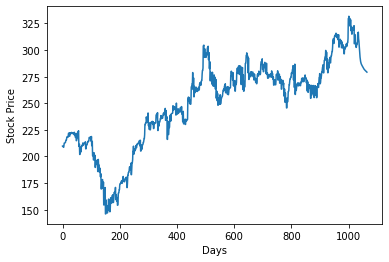

In [77]:
# tranformed it back to original image with 30 future days
plt.plot(df2)
plt.xlabel("Days")
plt.ylabel("Stock Price")
